In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import tqdm
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from src.path import ROOT

# trajectory length
SEQ_LENGTH: int = 48

# cuda flag
USE_CUDA: bool = True

if USE_CUDA and not torch.cuda.is_available():
    USE_CUDA = False
    print('fallback to cpu as CUDA is not available on this device')

fallback to cpu as CUDA is not available on this device


In [ ]:
import os
from datetime import date
from src.data_preprocess.trajectory import from_dataframe

In [ ]:
dataset_path='/content/drive/MyDrive/9900/geo_final'
test_files=['Mon.csv','Tue.csv','Wed.csv','Thu.csv','Fri.csv','Sat.csv','Sun.csv']

In [ ]:
from src.data_preprocess.trajectory import from_dataframe, Trajectory

test_trajectories: list[dict[str, Trajectory]] = [None] * len(test_files)

for i in tqdm.trange(len(test_files)):
    fname = test_files[i]
    df=pd.read_csv(f'{dataset_path}/{fname}')
    df['uid']=df['uid'].astype(str)
    test_trajectories[i] = from_dataframe(df, SEQ_LENGTH)

100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


Optional: remove stationary users

In [ ]:
min_unique_loc_count = 3

for i in range(len(test_trajectories)):
    test_trajectories[i] = {
        uid: trajectory
        for uid, trajectory in test_trajectories[i].items()
        if len(set(trajectory.points)) >= min_unique_loc_count
    }

Optional: remove non-persistent users

In [ ]:
from src.utils import set_intersect

persistent_users = set_intersect(*(trajectories.keys() for trajectories in test_trajectories))

for i in range(len(test_trajectories)):
    test_trajectories[i] = {
        uid: trajectory
        for uid, trajectory in test_trajectories[i].items()
        if uid in persistent_users
    }

len(persistent_users)

32

In [ ]:
from src.main.baseline import RecoveryFromAshDistance

ref_lat = 39.98090024220946
ref_long = 39.98090024220946

day_timestamp = 12

distance_metric = RecoveryFromAshDistance(ref=(ref_lat, ref_long), day_time=day_timestamp)

night time trajectory Recovery

In [ ]:
from src.main.baseline import DailyTrajectoryRecovery, get_aggregated_observations

predicted: list[list[Trajectory]] = [None] * len(test_trajectories)

for i in tqdm.trange(0, len(test_trajectories), desc='night time recovery'):
    trajectories = [Trajectory(t.points[:day_timestamp]) for t in test_trajectories[i].values()]

    algorithm = DailyTrajectoryRecovery(
        get_observations=lambda t: get_aggregated_observations(trajectories, t),
        cost_matrix=distance_metric.compute,
        sequence_length=day_timestamp,
        sequence_count=len(trajectories)
    )

    algorithm.run(verbose=False)
    predicted[i] = algorithm.get_predicted_trajectories()

night time recovery: 100%|██████████| 7/7 [00:00<00:00, 212.50it/s]


Evaluate

In [ ]:
from src.eval.metrics import greedy_match, similarity, mean_distance

avg_accuracy: float = 0
avg_recovery_error: float = 0

for predicted_trajectories, target_trajectories in tqdm.tqdm(zip(predicted, test_trajectories), total=len(predicted)):
    target_trajectories = [Trajectory(t.points[:day_timestamp]) for t in target_trajectories.values()]

    indices = greedy_match(predicted_trajectories, target_trajectories)
    n_trajectories = len(predicted_trajectories)

    accuracy = similarity(
        np.array(predicted_trajectories),
        np.array(target_trajectories)[indices]
    ).mean()

    recovery_error = mean_distance(
        np.array(predicted_trajectories),
        np.array(target_trajectories)[indices]
    ).mean() / 1000

    avg_accuracy += accuracy / len(test_trajectories)
    avg_recovery_error += recovery_error / len(test_trajectories)

print(f'average accuracy: {avg_accuracy}')
print(f'average recovery error: {avg_recovery_error}')

100%|██████████| 7/7 [00:00<00:00, 250.94it/s]

average accuracy: 0.8273809523809523
average recovery error: 1.0603573049982804


single day trajectory recovery (night time + day time)

In [ ]:
predicted: list[list[Trajectory]] = [None] * len(test_trajectories)

for i in tqdm.trange(0, len(test_trajectories), desc='night + day recovery'):
    trajectories = [Trajectory(t.points) for t in test_trajectories[i].values()]

    algorithm = DailyTrajectoryRecovery(
        get_observations=lambda t: get_aggregated_observations(trajectories, t),
        cost_matrix=distance_metric.compute,
        sequence_length=SEQ_LENGTH,
        sequence_count=len(trajectories)
    )

    algorithm.run(verbose=False)
    predicted[i] = algorithm.get_predicted_trajectories()

night + day recovery: 100%|██████████| 7/7 [00:00<00:00, 31.53it/s]


Evaluate

In [ ]:
avg_accuracy: float = 0
avg_recovery_error: float = 0

for predicted_trajectories, target_trajectories in tqdm.tqdm(zip(predicted, test_trajectories), total=len(predicted)):
    target_trajectories = [*target_trajectories.values()]

    indices = greedy_match(predicted_trajectories, target_trajectories)
    n_trajectories = len(predicted_trajectories)

    accuracy = similarity(
        np.array(predicted_trajectories),
        np.array(target_trajectories)[indices]
    ).mean()

    recovery_error = mean_distance(
        np.array(predicted_trajectories),
        np.array(target_trajectories)[indices]
    ).mean() / 1000

    avg_accuracy += accuracy / len(test_trajectories)
    avg_recovery_error += recovery_error / len(test_trajectories)

print(f'average accuracy: {avg_accuracy}')
print(f'average recovery error: {avg_recovery_error}')

100%|██████████| 7/7 [00:00<00:00, 166.13it/s]

average accuracy: 0.6342075892857143
average recovery error: 3.622327006614227


cross-day trajectory recovery

In [ ]:
from src.utils import set_intersect

persistent_users = set_intersect(*(trajectories.keys() for trajectories in test_trajectories))

persistent_trajectories: list[dict[str, Trajectory]] = [None] * len(test_trajectories)

for i in range(len(test_trajectories)):
    persistent_trajectories[i] = {
        uid: trajectory
        for uid, trajectory in test_trajectories[i].items()
        if uid in persistent_users
    }

len(persistent_users)

32

single day trajectory recovery

In [ ]:
predicted: list[list[Trajectory]] = [None] * len(persistent_trajectories)

for i in tqdm.trange(0, len(persistent_trajectories), desc='night + day recovery'):
    trajectories = [Trajectory(t.points) for t in persistent_trajectories[i].values()]

    algorithm = DailyTrajectoryRecovery(
        get_observations=lambda t: get_aggregated_observations(trajectories, t),
        cost_matrix=distance_metric.compute,
        sequence_length=SEQ_LENGTH,
        sequence_count=len(trajectories)
    )

    algorithm.run(verbose=False)
    predicted[i] = algorithm.get_predicted_trajectories()

night + day recovery: 100%|██████████| 7/7 [00:00<00:00, 49.12it/s]


cross-day recovery

In [ ]:
from src.main.baseline import CrossDayTrajectoryRecovery

algorithm = CrossDayTrajectoryRecovery(predicted)
algorithm.run()

predicted_trajectories = algorithm.result

cross-day recovery: 100%|██████████| 6/6 [00:03<00:00,  1.51it/s]


Evaluate

average accuracy: 0.15699404761904762
average recovery error: 8.333409935598619


Text(0.5, 0, 'recovery error (km)')

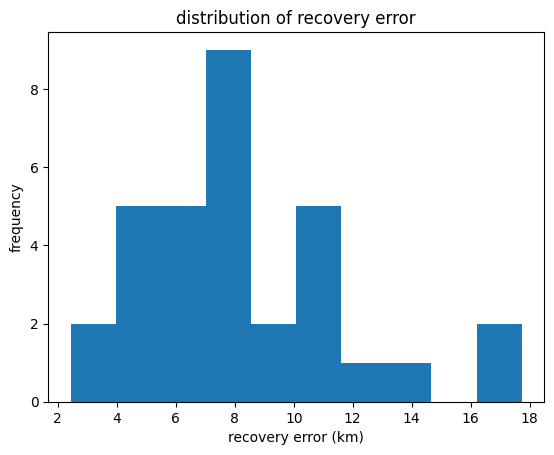

In [ ]:
import copy
from src.eval.metrics import similarity, mean_distance

# merge target trajectories
target_trajectories = copy.deepcopy(persistent_trajectories[0])

for uid, trajectory in target_trajectories.items():
    for i in range(1, len(persistent_trajectories)):
        trajectory.points += persistent_trajectories[i][uid].points

target_trajectories = [*target_trajectories.values()]

indices = greedy_match(predicted_trajectories, target_trajectories)

accuracy = similarity(
    np.array(predicted_trajectories),
    np.array(target_trajectories)[indices]
).mean()

print(f'average accuracy: {accuracy}')

distances = mean_distance(
    np.array(predicted_trajectories),
    np.array(target_trajectories)[indices]
) / 1000

print(f'average recovery error: {distances.mean()}')

plt.title('distribution of recovery error')
plt.hist(distances)
plt.ylabel('frequency')
plt.xlabel('recovery error (km)')

[0.0, 1.0, 1.0, 1.0, 1.0]


Text(0, 0.5, 'unique percentage')

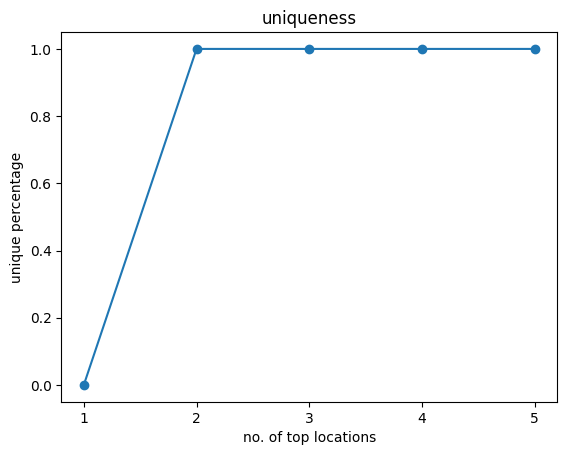

In [ ]:
from src.eval.metrics import uniqueness_list

uniqueness = [uniqueness_list(predicted_trajectories, i) for i in range(5)]
print(uniqueness)

plt.plot([str(i + 1) for i in range(5)], uniqueness, marker='o')
plt.title('uniqueness')
plt.xlabel('no. of top locations')
plt.ylabel('unique percentage')

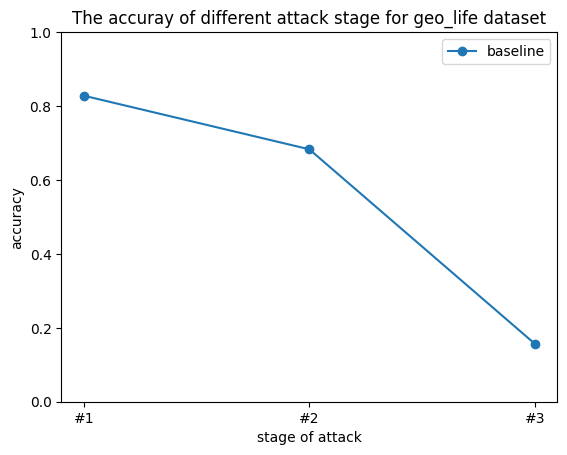

In [ ]:
plt.plot(['#1', '#2', '#3'], [0.828, 0.683, 0.157], marker='o', label='baseline')

plt.ylabel('accuracy')
plt.xlabel('stage of attack')
plt.title('The accuray of different attack stage for geo_life dataset')
plt.ylim((0, 1))
plt.legend()